In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from dateutil.relativedelta import relativedelta

# functions to create customised date x-axis

def keep_date(tdate, i, type, max=1):
    if type == '1m':
        return tdate.strftime('%d-%b') if i % 7 == 0 else ''
    elif type == '6m':
        return tdate.strftime('%d\n%b') if tdate.day == 1 else ''
    elif type == 'all':
        if tdate.day == 1:
            return tdate.strftime('%b\n%y') if tdate.month == 1 else tdate.strftime('%b') if tdate.month in [3, 5, 7, 9, 11] else ''
        else:
            return ''

def gen_date_xticks(date_list, type):
    ticks_dates = [pd.to_datetime(x) for x in date_list]
    ticks_dates.reverse()
    ticks_dates = [keep_date(ticks_dates[i], i, type) for i in range(len(ticks_dates))]
    ticks_dates.reverse()
    return ticks_dates

In [2]:
def time_zoom_chart(var='deaths'):

    col_use = ['date', 'deaths_new_dod'] if 'deaths' in var else ['date', 'cases_new']
    df = pd.read_csv(f'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/{var}_malaysia.csv', usecols=col_use)
    df.columns = ['date', var]
    df.date = pd.to_datetime(df.date).dt.date
    df[f'{var}_7d'] = df[var].rolling(7).mean()
    df.loc[df.date.isin(list(df.date.iloc[-7:])), f'{var}_7d'] = np.nan

    date_latest = df.date.iloc[-1]
    date_short = date_latest - relativedelta(months=1)
    date_mid = date_latest - relativedelta(months=6)

    df_views = {
        0: df.copy(),
        1: df.tail((date_latest-date_mid).days+1),
        2: df.tail((date_latest-date_short).days+1)
    }
    df_views_xticks = {
        0: gen_date_xticks(df_views[0].date.tolist(), 'all'),
        1: gen_date_xticks(df_views[1].date.tolist(), '6m'),
        2: gen_date_xticks(df_views[2].date.tolist(), '1m'),
    }

    plt.rcParams.update({'font.size': 11,
                        'font.family': 'sans-serif',
                         'grid.linestyle': 'dashed',
                         'figure.figsize': [7, 14],
                         'figure.autolayout': True})
    fig, ax = plt.subplots(3, 1)
    axes = ax.ravel()

    for i in range(3):
        dfp = df_views[i]
        dfp = dfp.reset_index(drop=True)
        dfp.date = pd.to_datetime(dfp.date)
        plot_range = dfp.date.iloc[0].strftime('%d-%b-%Y') + ' to ' + dfp.date.iloc[-1].strftime('%d-%b-%Y')

        dfp[var].plot(kind='bar', color='lightgrey', ax=axes[i])
        dfp[f'{var}_7d'].plot(kind='line', marker=None, color='red', ax=axes[i])
        axes[i].set_axisbelow(True)
        axes[i].yaxis.grid(True)
        axes[i].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # comma-sep y-axis
        axes[i].set(xticklabels=df_views_xticks[i]) # custom x-axis labels
        axes[i].tick_params(axis='both', which='both', length=0) # remove ticks but keep labels
        axes[i].set_title(f'\n{plot_range}\n')

    plt.xlabel('')
    plt.ylabel('')
    title = 'Daily Deaths due to COVID-19 (by date of death)' if 'deaths' in var else 'Daily COVID-19 cases (by date of report)'
    plt.suptitle(title)
    plt.show()

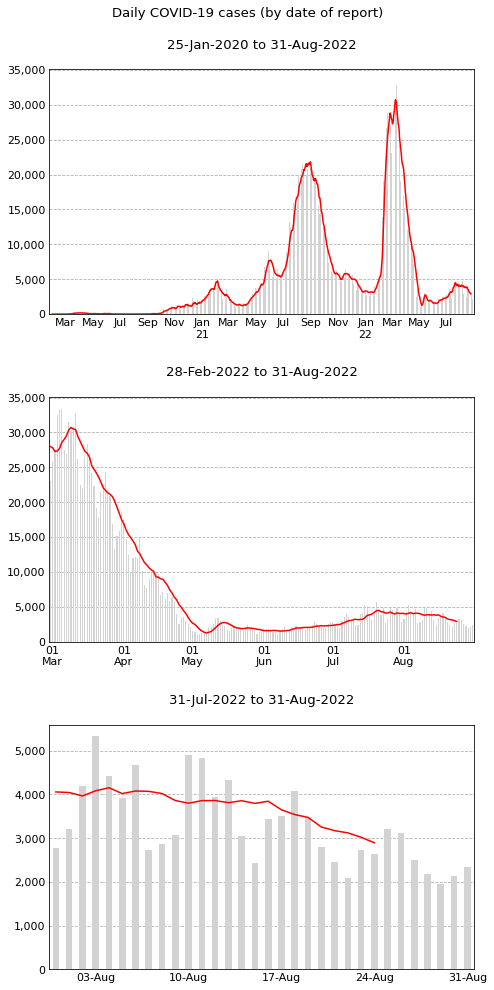

In [3]:
time_zoom_chart(var='cases')

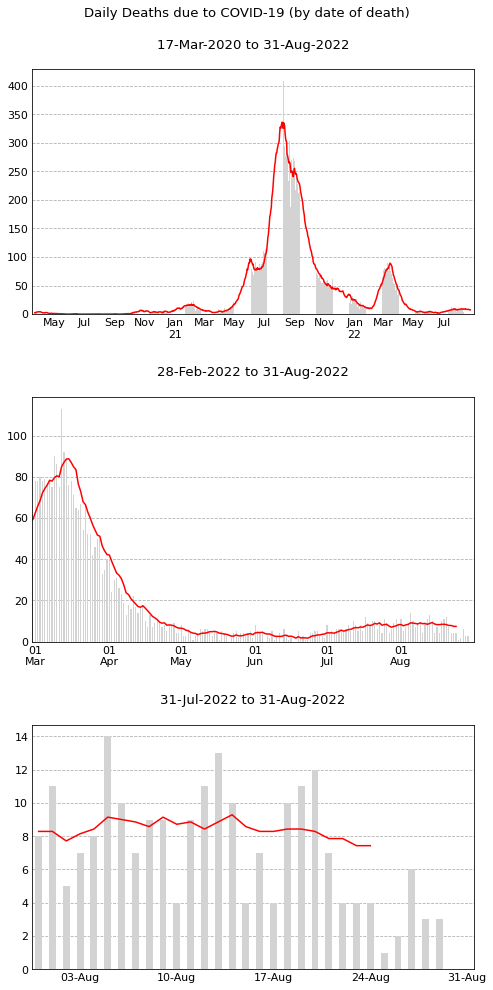

In [4]:
time_zoom_chart(var='deaths')